In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.stattools import acf

# Data Analysis

Here we conduct data analysis of the molecular dynamics simulation

# FINAL RESULTS

In [39]:
# Define all displacement (L) and temperature (T) values
L_values = list(range(130, 210, 10))  # L = 130, 140, ..., 200
T_values = [300, 600]  # T = 300K, 600K
Ns = 100000
Neq = 25000
Nrun = 1000000
ts = 10
td = 1000

# Base directory
base_dir = "lammps_project"

In [40]:
# Create an empty list to store data
data_list = []

# Loop over each L and T
for L in L_values:
    for T in T_values:
        folder_name = f"L{L}_T{T}_Ns{Ns}_Neq{Neq}_Nrun{Nrun}_ts{ts}_td{td}"
        forces_file = os.path.join(base_dir, folder_name, f"lmp{L}.forces")
        log_file = os.path.join(base_dir, folder_name, f"lmp{L}.log")

        # Load force and displacement data
        displacement, restoring_force = load_forces(forces_file)
        energy_data = load_energy(log_file)

        # Store as a dictionary
        if displacement is not None and restoring_force is not None:
            for i in range(len(displacement)):  # Loop over each data point
                data_list.append({
                    "L": L,
                    "T": T,
                    "displacement": displacement[i],
                    "force": restoring_force[i],
                    "energy": energy_data[i] if energy_data is not None and i < len(energy_data) else np.nan
                })

# Convert to Pandas DataFrame
df = pd.DataFrame(data_list)


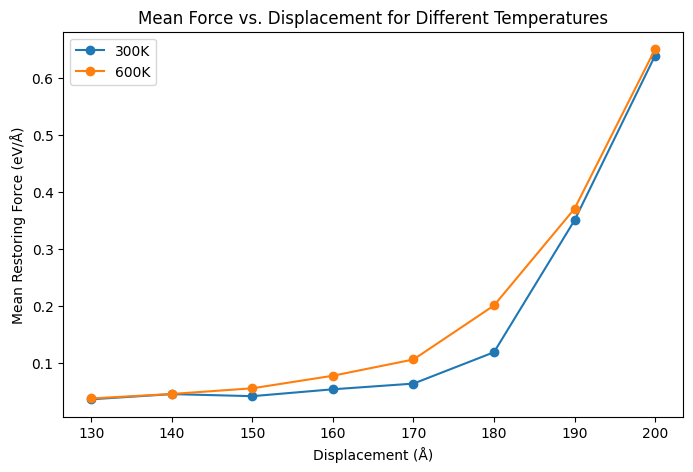

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean force per displacement & temperature
mean_force_df = df.groupby(["displacement", "T"])["force"].mean().reset_index()

plt.figure(figsize=(8,5))

for T in [300, 600]:
    temp_df = mean_force_df[mean_force_df["T"] == T]
    plt.plot(temp_df["displacement"], temp_df["force"], marker="o", linestyle="-", label=f"{T}K")

plt.xlabel("Displacement (Å)")
plt.ylabel("Mean Restoring Force (eV/Å)")
plt.title("Mean Force vs. Displacement for Different Temperatures")
plt.legend()
plt.show()



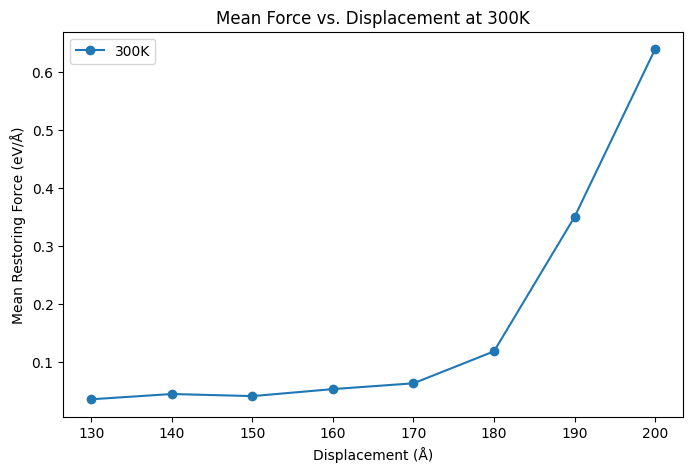

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean force per displacement at 300K
mean_force_300K = df[df["T"] == 300].groupby("displacement")["force"].mean().reset_index()

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(mean_force_300K["displacement"], mean_force_300K["force"], 
         marker="o", linestyle="-", color="tab:blue", label="300K")

# Labels and title
plt.xlabel("Displacement (Å)")
plt.ylabel("Mean Restoring Force (eV/Å)")
plt.title("Mean Force vs. Displacement at 300K")
plt.legend()

# Show the plot
plt.show()


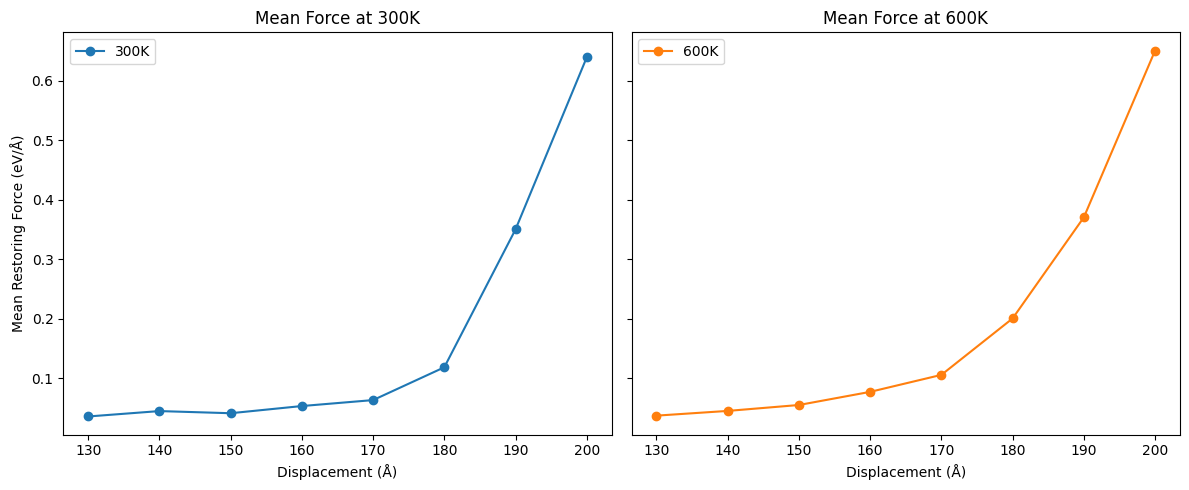

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean force per displacement & temperature
mean_force_df = df.groupby(["displacement", "T"])["force"].mean().reset_index()

# Define colors (blue for 300K, orange for 600K)
colors = {300: "tab:blue", 600: "tab:orange"}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, T in enumerate([300, 600]):
    temp_df = mean_force_df[mean_force_df["T"] == T]
    axes[i].plot(temp_df["displacement"], temp_df["force"], 
                 marker="o", linestyle="-", color=colors[T], label=f"{T}K")
    
    axes[i].set_xlabel("Displacement (Å)")
    axes[i].set_title(f"Mean Force at {T}K")
    axes[i].legend()

# Set common Y-axis label
axes[0].set_ylabel("Mean Restoring Force (eV/Å)")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


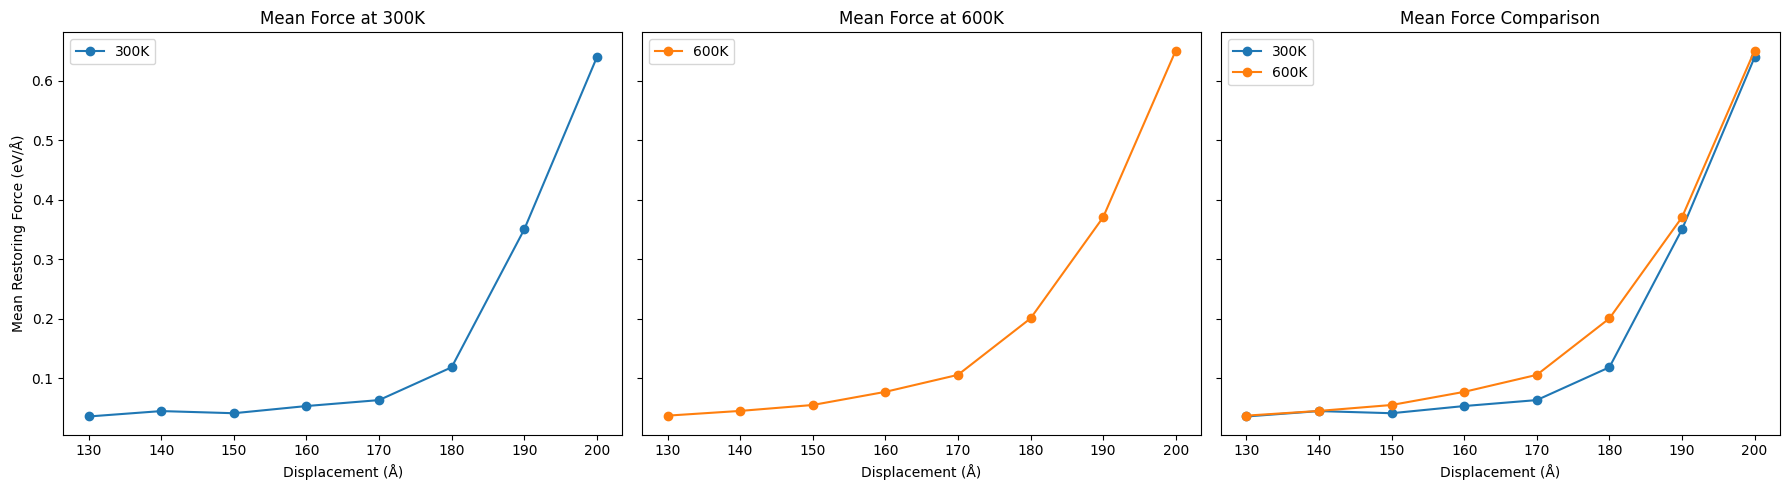

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean force per displacement & temperature
mean_force_df = df.groupby(["displacement", "T"])["force"].mean().reset_index()

# Define colors (blue for 300K, orange for 600K)
colors = {300: "tab:blue", 600: "tab:orange"}

# Create subplots (3 plots in a row)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot for 300K
temp_df_300 = mean_force_df[mean_force_df["T"] == 300]
axes[0].plot(temp_df_300["displacement"], temp_df_300["force"], 
             marker="o", linestyle="-", color=colors[300], label="300K")
axes[0].set_xlabel("Displacement (Å)")
axes[0].set_ylabel("Mean Restoring Force (eV/Å)")
axes[0].set_title("Mean Force at 300K")
axes[0].legend()

# Plot for 600K
temp_df_600 = mean_force_df[mean_force_df["T"] == 600]
axes[1].plot(temp_df_600["displacement"], temp_df_600["force"], 
             marker="o", linestyle="-", color=colors[600], label="600K")
axes[1].set_xlabel("Displacement (Å)")
axes[1].set_title("Mean Force at 600K")
axes[1].legend()

# Overlaid plot for comparison
axes[2].plot(temp_df_300["displacement"], temp_df_300["force"], 
             marker="o", linestyle="-", color=colors[300], label="300K")
axes[2].plot(temp_df_600["displacement"], temp_df_600["force"], 
             marker="o", linestyle="-", color=colors[600], label="600K")
axes[2].set_xlabel("Displacement (Å)")
axes[2].set_title("Mean Force Comparison")
axes[2].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Tau_int

In [86]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf

# Define function to compute tau_int
def compute_tau_int(series, nlags=1000):
    """Compute the integrated autocorrelation time (tau_int) for a given time series."""
    acf_values = acf(series, nlags=nlags, fft=True)
    
    # Find cutoff M (where ACF first crosses zero)
    M = np.argmax(acf_values < 0) if np.any(acf_values < 0) else nlags  # Use nlags if no zero-crossing
    
    # Compute tau_int using the sum formula
    tau_int = 0.5 + np.sum(acf_values[:M])  
    return tau_int

# Compute tau_int for each displacement-temperature pair
tau_int_results = []
for (L, T), group in df.groupby(["displacement", "T"]):
    tau = compute_tau_int(group["force"])  # No extra multiplication here!
    tau_int_results.append({"displacement": L, "T": T, "tau_int": tau * 10})  # Apply correction only once!

# Convert to DataFrame
tau_int_df = pd.DataFrame(tau_int_results)


# Convert to DataFrame
tau_int_df = pd.DataFrame(tau_int_results)

# Show computed tau_int values
print(tau_int_df)


    displacement    T    tau_int
0          130.0  300  16.858503
1          130.0  600  16.539906
2          140.0  300  16.581816
3          140.0  600  16.603882
4          150.0  300  16.329388
5          150.0  600  16.468412
6          160.0  300  16.824201
7          160.0  600  16.471855
8          170.0  300  16.552096
9          170.0  600  16.525637
10         180.0  300  15.888238
11         180.0  600  16.253100
12         190.0  300  16.226535
13         190.0  600  16.182358
14         200.0  300  15.876034
15         200.0  600  16.057378


### Error Bars

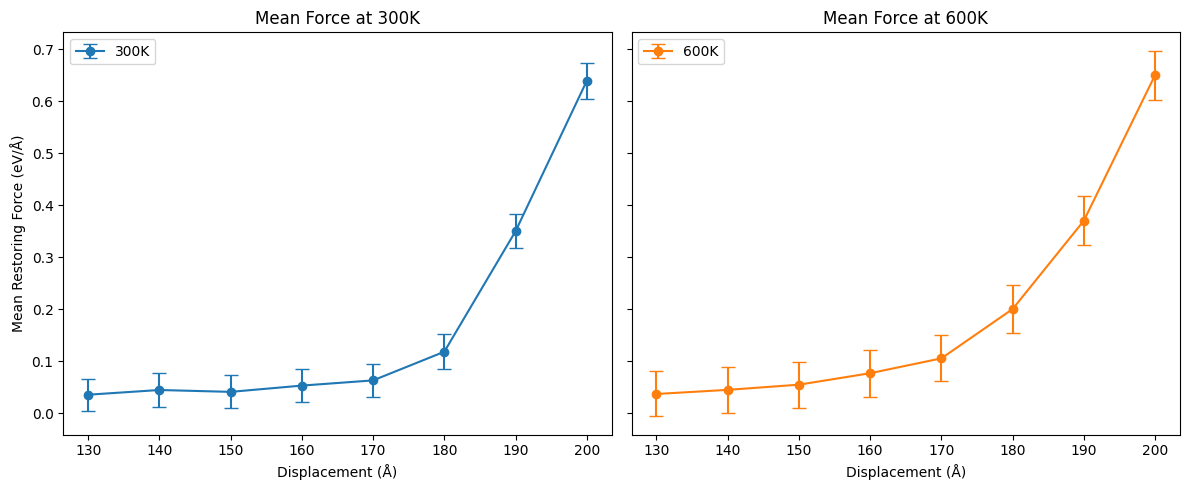

,displacement,T,tau_int,error
0,130.0,300,16.858503,0.030854
1,130.0,600,16.539906,0.043242
2,140.0,300,16.581816,0.032114
3,140.0,600,16.603882,0.043675
4,150.0,300,16.329388,0.031625
5,150.0,600,16.468412,0.043956
6,160.0,300,16.824201,0.032401
7,160.0,600,16.471855,0.044788
8,170.0,300,16.552096,0.031739
9,170.0,600,16.525637,0.044085


In [87]:
# Compute tau_int for each displacement-temperature pair
tau_int_results = []
for (L, T), group in df.groupby(["displacement", "T"]):
    tau = compute_tau_int(group["force"])  # No extra multiplication here!
    tau_int_results.append({"displacement": L, "T": T, "tau_int": tau * 10})  # Apply correction only once!

# Convert to DataFrame
tau_int_df = pd.DataFrame(tau_int_results)


# Convert to DataFrame
tau_int_df = pd.DataFrame(tau_int_results)

# Recompute mean and standard deviation of force per displacement & temperature
force_stats_df = df.groupby(["displacement", "T"])["force"].agg(["mean", "std"]).reset_index()
force_stats_df.rename(columns={"mean": "force_mean", "std": "force_std"}, inplace=True)

# Merge the exact N_total values and tau_int values
force_stats_df = force_stats_df.merge(N_total_df, on=["displacement", "T"])
force_stats_df = force_stats_df.merge(tau_int_df, on=["displacement", "T"])

# Compute effective sample size using actual tau_int values
force_stats_df["N_eff"] = force_stats_df["N_total"] / (2 * force_stats_df["tau_int"])

# Compute standard error using the correct formula
force_stats_df["error"] = force_stats_df["force_std"] / np.sqrt(force_stats_df["N_eff"])

# Define colors (blue for 300K, orange for 600K)
colors = {300: "tab:blue", 600: "tab:orange"}

# Create subplots for 300K and 600K
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, T in enumerate([300, 600]):
    temp_df = force_stats_df[force_stats_df["T"] == T]
    axes[i].errorbar(temp_df["displacement"], temp_df["force_mean"],
                     yerr=temp_df["error"], fmt="o-", color=colors[T], label=f"{T}K",
                     capsize=5, capthick=1)
    
    axes[i].set_xlabel("Displacement (Å)")
    axes[i].set_title(f"Mean Force at {T}K")
    axes[i].legend()

# Set common Y-axis label
axes[0].set_ylabel("Mean Restoring Force (eV/Å)")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Display the computed errors for verification
force_stats_df[["displacement", "T", "tau_int", "error"]]


In [88]:
# Compute effective sample size (N_eff) using the formula:
# N_eff = N_total / (2 * (10 * tau_int))

# Ensure tau_int is correctly assigned from previous computations
force_stats_df["N_eff"] = force_stats_df["N_total"] / (2 * force_stats_df["tau_int"])

# Display the computed N_eff values
force_stats_df[["displacement", "T", "tau_int", "N_total", "N_eff"]]


,displacement,T,tau_int,N_total,N_eff
0,130.0,300,16.858503,100001,2965.892041
1,130.0,600,16.539906,100001,3023.022086
2,140.0,300,16.581816,100001,3015.381420
3,140.0,600,16.603882,100001,3011.374157
4,150.0,300,16.329388,100001,3061.994782
5,150.0,600,16.468412,100001,3036.145728
6,160.0,300,16.824201,100001,2971.939131
7,160.0,600,16.471855,100001,3035.511240
8,170.0,300,16.552096,100001,3020.795634
9,170.0,600,16.525637,100001,3025.632200


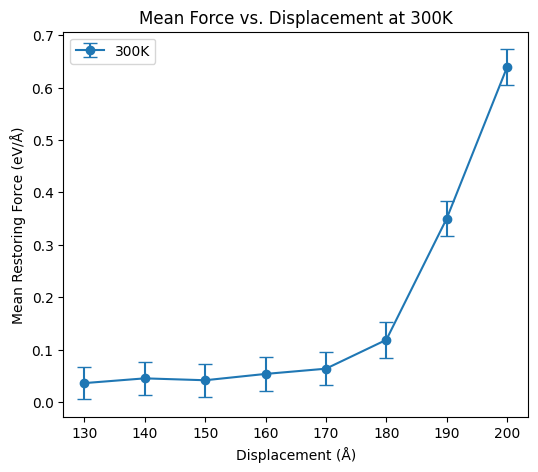

,displacement,T,tau_int,error
0,130.0,300,16.858503,0.030854
1,140.0,300,16.581816,0.032114
2,150.0,300,16.329388,0.031625
3,160.0,300,16.824201,0.032401
4,170.0,300,16.552096,0.031739
5,180.0,300,15.888238,0.033881
6,190.0,300,16.226535,0.033095
7,200.0,300,15.876034,0.034087


In [91]:
# Compute tau_int for each displacement-temperature pair (ONLY FOR 300K)
tau_int_results_300K = []
for (L, T), group in df.groupby(["displacement", "T"]):
    if T == 300:  # Filter for only 300K
        tau = compute_tau_int(group["force"])  # No extra multiplication here!
        tau_int_results_300K.append({"displacement": L, "T": T, "tau_int": tau * 10})  # Apply correction only once!

# Convert to DataFrame
tau_int_df_300K = pd.DataFrame(tau_int_results_300K)

# Recompute mean and standard deviation of force per displacement for 300K
force_stats_df_300K = df[df["T"] == 300].groupby(["displacement", "T"])["force"].agg(["mean", "std"]).reset_index()
force_stats_df_300K.rename(columns={"mean": "force_mean", "std": "force_std"}, inplace=True)

# Merge the exact N_total values and tau_int values for 300K
force_stats_df_300K = force_stats_df_300K.merge(N_total_df, on=["displacement", "T"])
force_stats_df_300K = force_stats_df_300K.merge(tau_int_df_300K, on=["displacement", "T"])

# Compute effective sample size using actual tau_int values for 300K
force_stats_df_300K["N_eff"] = force_stats_df_300K["N_total"] / (2 * force_stats_df_300K["tau_int"])

# Compute standard error using the correct formula for 300K
force_stats_df_300K["error"] = force_stats_df_300K["force_std"] / np.sqrt(force_stats_df_300K["N_eff"])

# Define color for 300K
color_300K = "tab:blue"

# Create plot for 300K only
plt.figure(figsize=(6, 5))
plt.errorbar(force_stats_df_300K["displacement"], force_stats_df_300K["force_mean"],
             yerr=force_stats_df_300K["error"], fmt="o-", color=color_300K, label="300K",
             capsize=5, capthick=1)

# Labels and title
plt.xlabel("Displacement (Å)")
plt.ylabel("Mean Restoring Force (eV/Å)")
plt.title("Mean Force vs. Displacement at 300K")
plt.legend()

# Show the plot
plt.show()

# Display the computed errors for verification
force_stats_df_300K[["displacement", "T", "tau_int", "error"]]


## Force Distributions

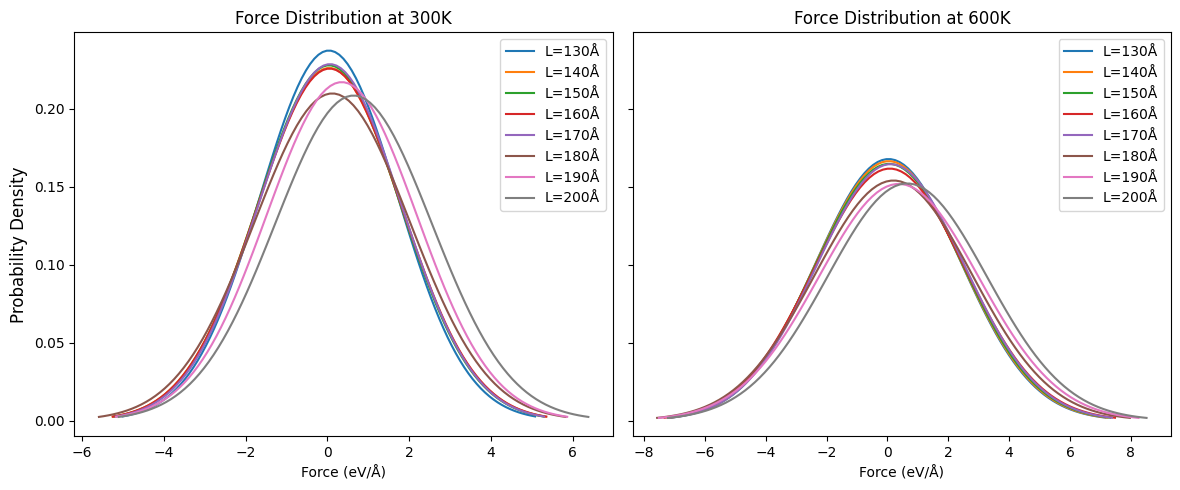

In [76]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Select displacement values to plot
L_values = list(range(130, 210, 10))  # L = 130, 140, ..., 200

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Two subplots for 300K & 600K

for i, T in enumerate([300, 600]):
    ax = axes[i]
    
    for L in L_values:
        temp_df = df[(df["T"] == T) & (df["displacement"] == L)]["force"]
        
        # Compute Gaussian fit parameters
        mu, sigma = np.mean(temp_df), np.std(temp_df)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        
        # Plot Gaussian curve
        ax.plot(x, stats.norm.pdf(x, mu, sigma), label=f"L={L}Å")
    
    # Labels and title
    ax.set_xlabel("Force (eV/Å)")
    ax.set_title(f"Force Distribution at {T}K")
    ax.legend()

# Common y-axis label
fig.supylabel("Probability Density")
plt.tight_layout()
plt.show()


<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8m/mlfdjz4d5bd1hd67c6nkhb_00000gn/T/ipykernel_2029/3697368904.py:44: SyntaxWarning: invalid escape sequence '\s'
  linestyle="dashed", color="gray", label="Expected $\sigma_F \propto \sqrt{T}$")


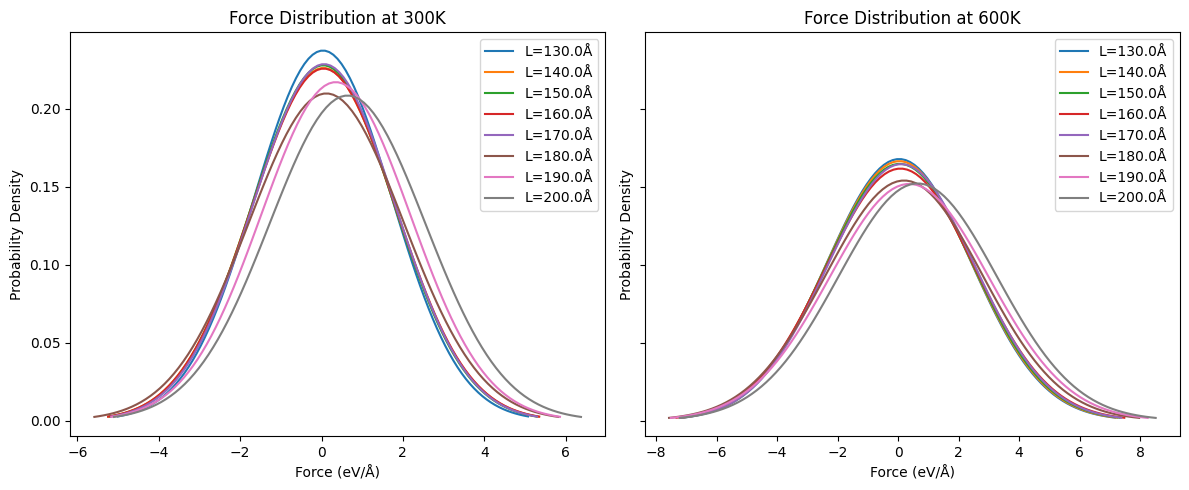

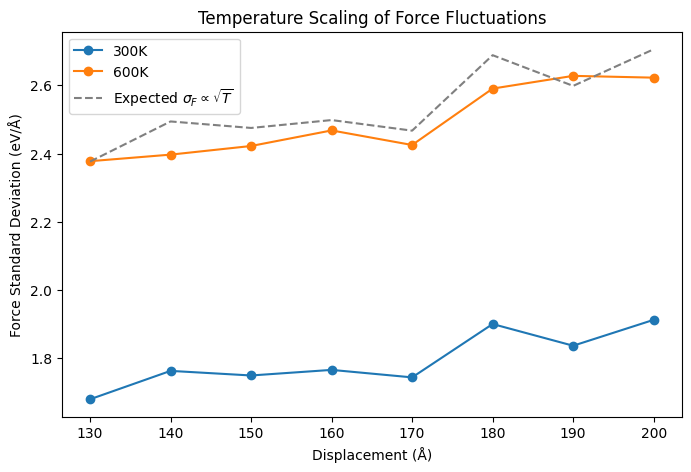

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Compute standard deviation of force fluctuations per displacement & temperature
force_fluctuations = df.groupby(["displacement", "T"])["force"].std().reset_index()
force_fluctuations.rename(columns={"force": "force_std"}, inplace=True)

# Create subplots for force fluctuation distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot force distributions with Gaussian fits
for i, T in enumerate([300, 600]):
    ax = axes[i]
    for L in df["displacement"].unique():
        subset = df[(df["displacement"] == L) & (df["T"] == T)]["force"]
        mu, sigma = np.mean(subset), np.std(subset)

        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        ax.plot(x, stats.norm.pdf(x, mu, sigma), label=f"L={L}Å")

    ax.set_title(f"Force Distribution at {T}K")
    ax.set_xlabel("Force (eV/Å)")
    ax.set_ylabel("Probability Density")
    ax.legend()

plt.tight_layout()
plt.show()


# --- 📌 TESTING TEMPERATURE SCALING OF FLUCTUATIONS ---
plt.figure(figsize=(8,5))

# Compute expected scaling from sqrt(T)
force_fluctuations["expected_scaling"] = force_fluctuations["force_std"] * np.sqrt(600 / 300)  # Scaling by sqrt(T)

for T in [300, 600]:
    temp_df = force_fluctuations[force_fluctuations["T"] == T]
    plt.plot(temp_df["displacement"], temp_df["force_std"], marker="o", linestyle="-", label=f"{T}K")

# Plot expected entropic scaling
plt.plot(temp_df["displacement"], force_fluctuations[force_fluctuations["T"] == 300]["expected_scaling"], 
         linestyle="dashed", color="gray", label="Expected $\sigma_F \propto \sqrt{T}$")

plt.xlabel("Displacement (Å)")
plt.ylabel("Force Standard Deviation (eV/Å)")
plt.title("Temperature Scaling of Force Fluctuations")
plt.legend()
plt.show()


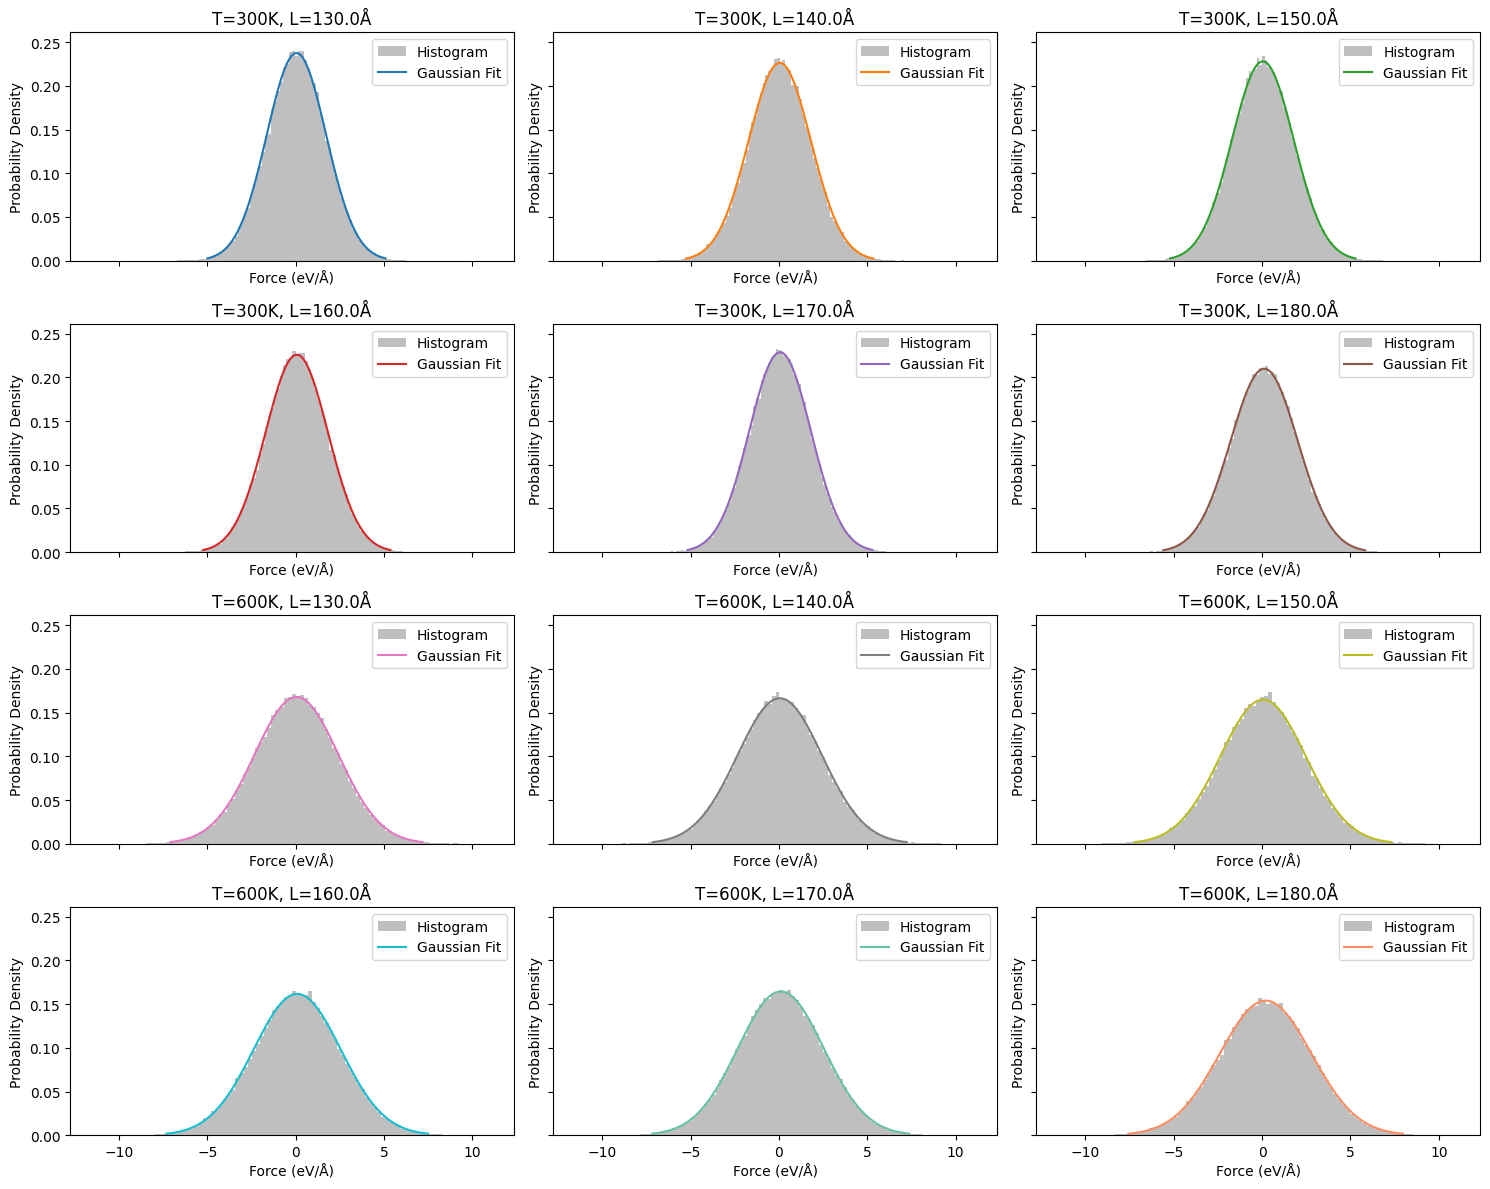

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define displacements to plot (6 for each temp)
selected_displacements = sorted(df["displacement"].unique())[:6]  # First 6 displacements

# Create a color cycle for Gaussians (12 unique colors)
colors = plt.cm.tab10.colors + plt.cm.Set2.colors  # Combine 2 colormaps

# Create a 4x3 subplot grid (2 rows per temperature)
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=True, sharey=True)

# Set global x and y limits for consistency
force_min, force_max = df["force"].min(), df["force"].max()
y_max = 0  # Placeholder for max y-axis value

# Loop over temperatures and displacements
for i, T in enumerate([300, 600]):
    for j, L in enumerate(selected_displacements):
        ax = axes[i * 2 + (j // 3), j % 3]  # Position in 4x3 grid
        
        # Get subset of force data
        subset = df[(df["displacement"] == L) & (df["T"] == T)]["force"]

        # Compute Gaussian fit parameters
        mu, sigma = np.mean(subset), np.std(subset)
        x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
        y = stats.norm.pdf(x, mu, sigma)

        # Update max y-axis value for consistency
        y_max = max(y_max, max(y))

        # Plot histogram (same color)
        ax.hist(subset, bins=100, density=True, alpha=0.5, color="gray", label="Histogram")

        # Plot Gaussian fit (unique color per subplot)
        ax.plot(x, y, label="Gaussian Fit", color=colors[i * 6 + j])

        # Titles & labels
        ax.set_title(f"T={T}K, L={L}Å")
        ax.set_xlabel("Force (eV/Å)")
        ax.set_ylabel("Probability Density")
        ax.legend()

# Set the same axis limits for all subplots
for ax in axes.flat:
    ax.set_xlim(force_min, force_max)
    ax.set_ylim(0, y_max * 1.1)  # Add a bit of padding

# Adjust layout for clarity
plt.tight_layout()
plt.show()


# Energy

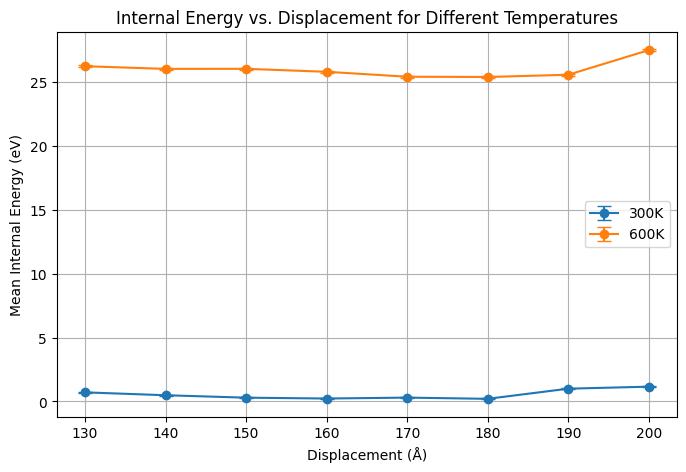

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf

# Define function to compute tau_int for energy
def compute_tau_int(series, nlags=1000):
    """Compute the integrated autocorrelation time (tau_int) for a given time series."""
    acf_values = acf(series, nlags=nlags, fft=True)
    
    # Find cutoff M (where ACF first crosses zero)
    M = np.argmax(acf_values < 0) if np.any(acf_values < 0) else nlags  # Use nlags if no zero-crossing
    
    # Compute tau_int using the sum formula
    tau_int = 0.5 + np.sum(acf_values[:M])  
    return tau_int

# Compute tau_int for energy per displacement-temperature pair
tau_int_energy_results = []
for (L, T), group in df.groupby(["displacement", "T"]):
    tau_energy = compute_tau_int(group["energy"]) * 10  # Apply the 10x correction for time steps
    tau_int_energy_results.append({"displacement": L, "T": T, "tau_int_energy": tau_energy})

# Convert to DataFrame
tau_int_energy_df = pd.DataFrame(tau_int_energy_results)

# Compute mean and standard deviation of internal energy per displacement & temperature
energy_stats_df = df.groupby(["displacement", "T"])["energy"].agg(["mean", "std"]).reset_index()
energy_stats_df.rename(columns={"mean": "energy_mean", "std": "energy_std"}, inplace=True)

# Merge the exact N_total values and tau_int values for energy
energy_stats_df = energy_stats_df.merge(N_total_df, on=["displacement", "T"])
energy_stats_df = energy_stats_df.merge(tau_int_energy_df, on=["displacement", "T"])

# Compute effective sample size for energy using the correct formula:
energy_stats_df["N_eff_energy"] = energy_stats_df["N_total"] / (2 * energy_stats_df["tau_int_energy"])

# Compute standard error using the correct formula
energy_stats_df["error_energy"] = energy_stats_df["energy_std"] / np.sqrt(energy_stats_df["N_eff_energy"])

# Define colors for temperature
colors = {300: "tab:blue", 600: "tab:orange"}

# Create a single plot
plt.figure(figsize=(8, 5))

for T in [300, 600]:
    temp_df = energy_stats_df[energy_stats_df["T"] == T]
    plt.errorbar(temp_df["displacement"], temp_df["energy_mean"], 
                 yerr=temp_df["error_energy"], fmt="o-", color=colors[T], label=f"{T}K",
                 capsize=5, capthick=1)

# Labels and title
plt.xlabel("Displacement (Å)")
plt.ylabel("Mean Internal Energy (eV)")
plt.title("Internal Energy vs. Displacement for Different Temperatures")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [104]:
print(energy_stats_df[["displacement", "T", "energy_std", "tau_int_energy", "error_energy"]])


    displacement    T  energy_std  tau_int_energy  error_energy
0          130.0  300    1.014024       90.780505      0.043207
1          130.0  600    1.756097       76.679229      0.068770
2          140.0  300    0.994880       87.979234      0.041732
3          140.0  600    1.742501       76.908850      0.068340
4          150.0  300    0.964740       82.036870      0.039078
5          150.0  600    1.717719       72.355871      0.065343
6          160.0  300    0.974727       86.773185      0.040606
7          160.0  600    1.719317       74.081967      0.066180
8          170.0  300    0.941292       78.036848      0.037187
9          170.0  600    1.715128       74.367651      0.066146
10         180.0  300    0.918487       71.343796      0.034695
11         180.0  600    1.727636       75.387667      0.067083
12         190.0  300    0.919732       71.188101      0.034704
13         190.0  600    1.739184       77.547849      0.068493
14         200.0  300    1.048026      1

In [105]:
print(energy_stats_df[["displacement", "T", "N_eff_energy", "error_energy"]])


    displacement    T  N_eff_energy  error_energy
0          130.0  300    550.784557      0.043207
1          130.0  600    652.073589      0.068770
2          140.0  300    568.321611      0.041732
3          140.0  600    650.126742      0.068340
4          150.0  300    609.488145      0.039078
5          150.0  600    691.035835      0.065343
6          160.0  300    576.220636      0.040606
7          160.0  600    674.934836      0.066180
8          170.0  300    640.729364      0.037187
9          170.0  600    672.342065      0.066146
10         180.0  300    700.838791      0.034695
11         180.0  600    663.245091      0.067083
12         190.0  300    702.371598      0.034704
13         190.0  600    644.769654      0.068493
14         200.0  300    493.679652      0.047168
15         200.0  600    655.112542      0.068010


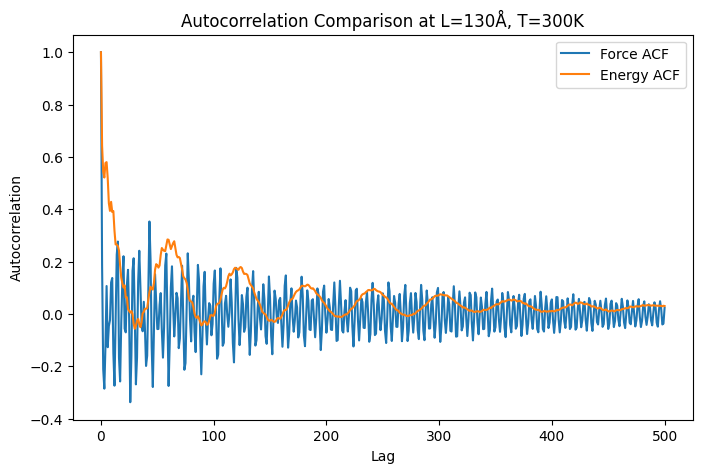

In [120]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

L_check = 130  # Pick a displacement
T_check = 300  # Pick a temperature

# Extract energy and force timeseries
force_series = df[(df["displacement"] == L_check) & (df["T"] == T_check)]["force"]
energy_series = df[(df["displacement"] == L_check) & (df["T"] == T_check)]["energy"]

# Compute autocorrelations
acf_force = acf(force_series, nlags=500, fft=True)
acf_energy = acf(energy_series, nlags=500, fft=True)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(acf_force, label="Force ACF", color="tab:blue")
plt.plot(acf_energy, label="Energy ACF", color="tab:orange")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title(f"Autocorrelation Comparison at L={L_check}Å, T={T_check}K")
plt.legend()
plt.show()


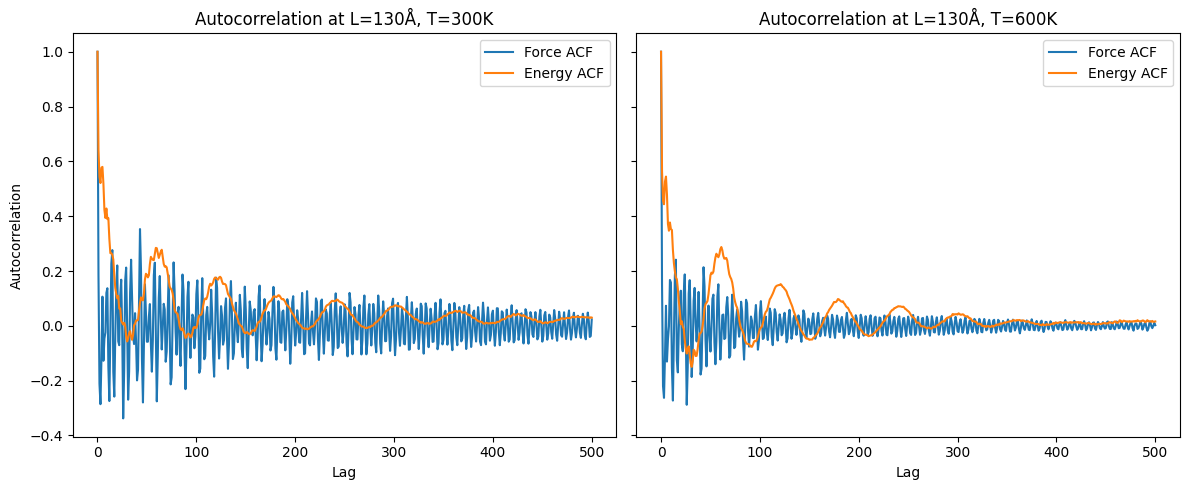

In [122]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

L_check = 130  # Pick a displacement
temperatures = [300, 600]  # Analyze for both temperatures

# Create subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, T_check in enumerate(temperatures):
    # Extract energy and force timeseries
    force_series = df[(df["displacement"] == L_check) & (df["T"] == T_check)]["force"]
    energy_series = df[(df["displacement"] == L_check) & (df["T"] == T_check)]["energy"]

    # Compute autocorrelations
    acf_force = acf(force_series, nlags=500, fft=True)
    acf_energy = acf(energy_series, nlags=500, fft=True)

    # Plot
    ax = axes[i]
    ax.plot(acf_force, label="Force ACF", color="tab:blue")
    ax.plot(acf_energy, label="Energy ACF", color="tab:orange")
    ax.set_xlabel("Lag")
    ax.set_title(f"Autocorrelation at L={L_check}Å, T={T_check}K")
    ax.legend()

# Set common Y-axis label
axes[0].set_ylabel("Autocorrelation")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


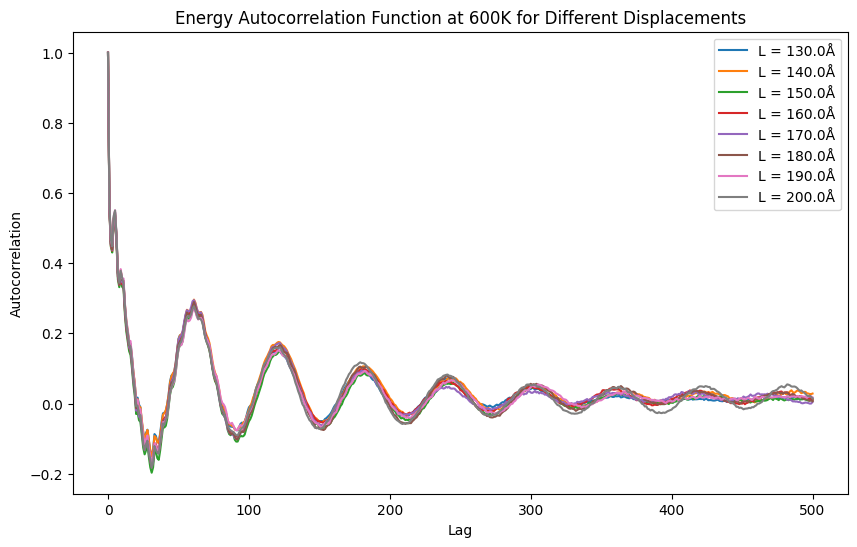

In [121]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Select a single temperature (300K)
selected_temp = 600

# Define displacement values
displacements = sorted(df[df["T"] == selected_temp]["displacement"].unique())

# Create a plot for energy ACF across all displacements at 300K
plt.figure(figsize=(10, 6))

for L in displacements:
    subset = df[(df["displacement"] == L) & (df["T"] == selected_temp)]["energy"]
    acf_values = acf(subset, nlags=500, fft=True)
    
    plt.plot(acf_values, label=f"L = {L}Å")

plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title(f"Energy Autocorrelation Function at {selected_temp}K for Different Displacements")
plt.legend()
plt.show()
